# How to build RNNs and LSTMs from scratch

Originally developed by me (Nicklas Hansen), Peter Christensen and Alexander Johansen as educational material for the graduate deep learning course at the Technical University of Denmark (DTU). You can access the full course material [here](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch).
____

In this lab we will introduce different ways of learning from sequential data.
As an example, we will train a neural network to do language modelling, i.e. predict the next token in a sentence. In the context of natural language processing a token could be a character or a word, but mind you that the concepts introduced here apply to all kinds of sequential data, such as e.g. protein sequences, weather measurements, audio signals or monetary transaction history, just to name a few.

To really get a grasp of what is going on inside the recurrent neural networks that we are about to teach you, we will carry out a substantial part of this exercise in numpy rather than PyTorch. Once you get a hold of it, we will proceed to the PyTorch implementation.

In this notebook we will show you:
* How to represent categorical variables in networks
* How to build a recurrent neural network (RNN) from scratch
* How to build a LSTM network from scratch
* How to build a LSTM network in PyTorch

## Representing tokens or text

In previous labs we mainly considered data $x \in \mathrm{R}^d$, where $d$ is the feature space dimension.
With time sequences our data can be represented as $x \in \mathrm{R}^{t \, \times \, d}$, where $t$ is the sequence length. 
This emphasises sequence dependence and that the samples along the sequence are not independent and identically distributed (i.i.d.).
We will model functions as $\mathrm{R}^{t \, \times \, d} \rightarrow \mathrm{R}^c$, where $c$ is the amount of classes in the output.

There are several ways to represent sequences. With text, the challenge is how to represent a word as a feature vector in $d$ dimensions, as we are required to represent text with decimal numbers in order to apply neural networks to it.

In this exercise we will use a simple one-hot encoding but for categorical variables that can take on many values (e.g. words in the English language) this may be infeasible. For such scenarios, you can project the encodings into a smaller space by use of embeddings. If you want to learn more about tokens, encodings and embeddings than what is covered in this exercise, we highly recommend [this lecture](https://www.youtube.com/watch?v=kEMJRjEdNzM&list=PLoROMvodv4rOhcuXMZkNm7j3fVwBBY42z).

### One-hot encoding over vocabulary

One way to represent a fixed amount of words is by making a one-hot encoded vector, which consists of 0s in all cells with the exception of a single 1 in a cell used uniquely to identify each word.

| vocabulary    | one-hot encoded vector   |
| ------------- |--------------------------|
| Paris         | $= [1, 0, 0, \ldots, 0]$ |
| Rome          | $= [0, 1, 0, \ldots, 0]$ |
| Copenhagen    | $= [0, 0, 1, \ldots, 0]$ |

Representing a large vocabulary with one-hot encodings often becomes inefficient because of the size of each sparse vector.
To overcome this challenge it is common practice to truncate the vocabulary to contain the $k$ most used words and represent the rest with a special symbol, $\mathtt{UNK}$, to define unknown/unimportant words.
This often causes entities such as names to be represented with $\mathtt{UNK}$ because they are rare.

Consider the following text
> I love the corny jokes in Spielberg's new movie.

where an example result would be similar to
> I love the corny jokes in $\mathtt{UNK}$'s new movie.

## Generating a dataset

For this exercise we will create a simple dataset that we can learn from. We generate sequences of the form:

`a a a a b b b b EOS`, `a a b b EOS`, `a a a a a b b b b b EOS`

where `EOS` is a special character denoting the end of a sequence. The task is to predict the next token $t_n$, i.e. `a`, `b`, `EOS` or the unknown token `UNK` given the sequence of tokens $\{ t_{1}, t_{2}, \dots , t_{n-1}\}$ and we are to process sequences in a sequential manner. As such, the network will need to learn that e.g. 5 `b`s and an `EOS` token will occur following 5 `a`s.

In [1]:
import numpy as np

# Set seed such that we always get the same dataset
np.random.seed(42)

def generate_dataset(num_sequences=100):
    """
    Generates a number of sequences as our dataset.
    
    Args:
     `num_sequences`: the number of sequences to be generated.
     
    Returns a list of sequences.
    """
    samples = []
    
    for _ in range(num_sequences): 
        num_tokens = np.random.randint(1, 10)
        sample = ['a'] * num_tokens + ['b'] * num_tokens + ['EOS']
        samples.append(sample)
        
    return samples


sequences = generate_dataset()

print('A single sample from the generated dataset:')
print(sequences[0])

A single sample from the generated dataset:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']


## Representing tokens as indices

To build a one-hot encoding, we need to assign each possible word in our vocabulary an index. We do that by creating two dictionaries: one that allows us to go from a given word to its corresponding index in our vocabulary, and one for the reverse direction. Let's call them `word_to_idx` and `idx_to_word`. The keyword `num_words` specifies the maximum size of our vocabulary. If we try to access a word that does not exist in our vocabulary, it is automatically replaced by the `UNK` token or its corresponding index.

In [2]:
from collections import defaultdict

def sequences_to_dicts(sequences):
    """
    Creates word_to_idx and idx_to_word dictionaries for a list of sequences.
    """
    # A bit of Python-magic to flatten a nested list
    flatten = lambda l: [item for sublist in l for item in sublist]
    
    # Flatten the dataset
    all_words = flatten(sequences)
    
    # Count number of word occurences
    word_count = defaultdict(int)
    for word in flatten(sequences):
        word_count[word] += 1

    # Sort by frequency
    word_count = sorted(list(word_count.items()), key=lambda l: -l[1])

    # Create a list of all unique words
    unique_words = [item[0] for item in word_count]
    
    # Add UNK token to list of words
    unique_words.append('UNK')

    # Count number of sequences and number of unique words
    num_sentences, vocab_size = len(sequences), len(unique_words)

    # Create dictionaries so that we can go from word to index and back
    # If a word is not in our vocabulary, we assign it to token 'UNK'
    word_to_idx = defaultdict(lambda: num_words)
    idx_to_word = defaultdict(lambda: 'UNK')

    # Fill dictionaries
    for idx, word in enumerate(unique_words):
        # YOUR CODE HERE!
        word_to_idx[word] = idx
        idx_to_word[idx] = word

    return word_to_idx, idx_to_word, num_sentences, vocab_size


word_to_idx, idx_to_word, num_sequences, vocab_size = sequences_to_dicts(sequences)

print(f'We have {num_sequences} sentences and {len(word_to_idx)} unique tokens in our dataset (including UNK).\n')
print('The index of \'b\' is', word_to_idx['b'])
print(f'The word corresponding to index 1 is \'{idx_to_word[1]}\'')

We have 100 sentences and 4 unique tokens in our dataset (including UNK).

The index of 'b' is 1
The word corresponding to index 1 is 'b'


## Exercise:

Complete the `sequences_to_dicts` function above. You will need to fill the `word_to_idx` and `idx_to_word` dictionaries so that we can go back and forth between the two representations.

## Partitioning the dataset

To build our dataset, we need to create inputs and targets for each sequences and partition sentences it into training, validation and test sets. 80%, 10% and 10% is a common distribution, but mind you that this largely depends on the size of the dataset. Since we are doing next-word predictions, our target sequence is simply the input sequence shifted by one word.

We can use PyTorch's `Dataset` class to build a simple dataset where we can easily retrieve (inputs, targets) pairs for each of our sequences.

In [3]:
from torch.utils import data

class Dataset(data.Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        # Return the size of the dataset
        return len(self.targets)

    def __getitem__(self, index):
        # Retrieve inputs and targets at the given index
        X = self.inputs[index]
        y = self.targets[index]

        return X, y

    
def create_datasets(sequences, dataset_class, p_train=0.8, p_val=0.1, p_test=0.1):
    # Define partition sizes
    num_train = int(len(sequences)*p_train)
    num_val = int(len(sequences)*p_val)
    num_test = int(len(sequences)*p_test)

    # Split sequences into partitions
    sequences_train = sequences[:num_train]
    sequences_val = sequences[num_train:num_train+num_val]
    sequences_test = sequences[-num_test:]

    def get_inputs_targets_from_sequences(sequences):
        # Define empty lists
        inputs, targets = [], []
        
        # Append inputs and targets s.t. both lists contain L-1 words of a sentence of length L
        # but targets are shifted right by one so that we can predict the next word
        for sequence in sequences:
            inputs.append(sequence[:-1])
            targets.append(sequence[1:])
            
        return inputs, targets

    # Get inputs and targets for each partition
    inputs_train, targets_train = get_inputs_targets_from_sequences(sequences_train)
    inputs_val, targets_val = get_inputs_targets_from_sequences(sequences_val)
    inputs_test, targets_test = get_inputs_targets_from_sequences(sequences_test)

    # Create datasets
    training_set = dataset_class(inputs_train, targets_train)
    validation_set = dataset_class(inputs_val, targets_val)
    test_set = dataset_class(inputs_test, targets_test)

    return training_set, validation_set, test_set
    

training_set, validation_set, test_set = create_datasets(sequences, Dataset)

print(f'We have {len(training_set)} samples in the training set.')
print(f'We have {len(validation_set)} samples in the validation set.')
print(f'We have {len(test_set)} samples in the test set.')

We have 80 samples in the training set.
We have 10 samples in the validation set.
We have 10 samples in the test set.


When working with more complex data than what we use in this exercise, creating a PyTorch `DataLoader` on top of the dataset can be beneficial. A data loader is basically a fancy generator/iterator that we can use to abstract away all of the data handling and pre-processing + it's super useful for processing batches of data as well! Data loaders will come in handy later when you start to work on your projects, so be sure to check them out!

For more information on how to use datasets and data loaders in PyTorch, [consult the official guide](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

## One-hot encodings

We now create a simple function that returns the one-hot encoded representation of a given index of a word in our vocabulary. Notice that the shape of the one-hot encoding is equal to the vocabulary (which can be huge!). Additionally, we define a function to automatically one-hot encode a sentence.

In [4]:
def one_hot_encode(idx, vocab_size):
    """
    One-hot encodes a single word given its index and the size of the vocabulary.
    
    Args:
     `idx`: the index of the given word
     `vocab_size`: the size of the vocabulary
    
    Returns a 1-D numpy array of length `vocab_size`.
    """
    # Initialize the encoded array
    one_hot = np.zeros(vocab_size)
    
    # Set the appropriate element to one
    one_hot[idx] = 1.0

    return one_hot


def one_hot_encode_sequence(sequence, vocab_size):
    """
    One-hot encodes a sequence of words given a fixed vocabulary size.
    
    Args:
     `sentence`: a list of words to encode
     `vocab_size`: the size of the vocabulary
     
    Returns a 3-D numpy array of shape (num words, vocab size, 1).
    """
    # Encode each word in the sentence
    encoding = np.array([one_hot_encode(word_to_idx[word], vocab_size) for word in sequence])

    # Reshape encoding s.t. it has shape (num words, vocab size, 1)
    encoding = encoding.reshape(encoding.shape[0], encoding.shape[1], 1)
    
    return encoding


test_word = one_hot_encode(word_to_idx['a'], vocab_size)
print(f'Our one-hot encoding of \'a\' has shape {test_word.shape}.')

test_sentence = one_hot_encode_sequence(['a', 'b'], vocab_size)
print(f'Our one-hot encoding of \'a b\' has shape {test_sentence.shape}.')

Our one-hot encoding of 'a' has shape (4,).
Our one-hot encoding of 'a b' has shape (2, 4, 1).


Great! Now that we have our one-hot encodings in place, we can move on to the RNNs!

# Introduction to Recurrent Neural Networks (RNN)

Reading material: [blog post](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) and (optionally) [this lecture](https://www.youtube.com/watch?v=iWea12EAu6U&list=PLoROMvodv4rOhcuXMZkNm7j3fVwBBY42z).

___

A recurrent neural network (RNN) is a type of neural network that has been succesful in modelling sequential data, e.g. language, speech, protein sequences, etc.

A RNN performs its computations in a cyclic manner, where the same computation is applied to every sample of a given sequence.
The idea is that the network should be able to use the previous computations as some form of memory and apply this to future computations.
An image may best explain how this is to be understood,

![rnn-unroll image](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/rnn-unfold.png?raw=1)


where it the network contains the following elements:

- $x$ is the input sequence of samples, 
- $U$ is a weight matrix applied to the given input sample,
- $V$ is a weight matrix used for the recurrent computation in order to pass memory along the sequence,
- $W$ is a weight matrix used to compute the output of the every timestep (given that every timestep requires an output),
- $h$ is the hidden state (the network's memory) for a given time step, and
- $o$ is the resulting output.

When the network is unrolled as shown, it is easier to refer to a timestep, $t$.
We have the following computations through the network:

- $h_t = f(U\,{x_t} + V\,{h_{t-1}})$, where $f$ usually is an activation function, e.g. $\mathrm{tanh}$.
- $o_t = \mathrm{softmax}(W\,{h_t})$

## Implementing a RNN

We will implement the forward pass, backward pass, optimization and training loop for a RNN in numpy so that you can get familiar with the recurrent nature of RNNs. Later, we will go back to PyTorch and appreciate how convenient the implementation becomes.

Let's define the necessary model parameters. Recall that an $n \times m$ weight matrix maps $\mathbb{R}^{m} \rightarrow \mathbb{R}^{n}$.

In [5]:
hidden_size = 50 # Number of dimensions in the hidden state
vocab_size  = len(word_to_idx) # Size of the vocabulary used

def init_orthogonal(param):
    """
    Initializes weight parameters orthogonally.
    
    Refer to this paper for an explanation of this initialization:
    https://arxiv.org/abs/1312.6120
    """
    if param.ndim < 2:
        raise ValueError("Only parameters with 2 or more dimensions are supported.")

    rows, cols = param.shape
    
    new_param = np.random.randn(rows, cols)
    
    if rows < cols:
        new_param = new_param.T
    
    # Compute QR factorization
    q, r = np.linalg.qr(new_param)
    
    # Make Q uniform according to https://arxiv.org/pdf/math-ph/0609050.pdf
    d = np.diag(r, 0)
    ph = np.sign(d)
    q *= ph

    if rows < cols:
        q = q.T
    
    new_param = q
    
    return new_param


def init_rnn(hidden_size, vocab_size):
    """
    Initializes our recurrent neural network.
    
    Args:
     `hidden_size`: the dimensions of the hidden state
     `vocab_size`: the dimensions of our vocabulary
    """
    # Weight matrix (input to hidden state)
    # YOUR CODE HERE!
    U = np.zeros((hidden_size, vocab_size))

    # Weight matrix (recurrent computation)
    # YOUR CODE HERE!
    V = np.zeros((hidden_size, hidden_size))

    # Weight matrix (hidden state to output)
    # YOUR CODE HERE!
    W = np.zeros((vocab_size, hidden_size))

    # Bias (hidden state)
    # YOUR CODE HERE!
    b_hidden = np.zeros((hidden_size, 1))

    # Bias (output)
    # YOUR CODE HERE!
    b_out = np.zeros((vocab_size, 1))
    
    # Initialize weights
    U = init_orthogonal(U)
    V = init_orthogonal(V)
    W = init_orthogonal(W)
    
    # Return parameters as a tuple
    return U, V, W, b_hidden, b_out


params = init_rnn(hidden_size=hidden_size, vocab_size=vocab_size)

## Exercise:

Define the appropriate shape of the weights and biases in the `init_rnn` function.

You only have to worry about the weight and bias dimensions; you can leave the scaling as is. Refer to the equations and figure above if you're in doubt here.

### Function definitions

Below we have defined the `sigmoid`, `tanh` and `softmax` functions. You might need them in a bit!

#### Sigmoid activation

In [6]:
def sigmoid(x, derivative=False):
    """
    Computes the element-wise sigmoid activation function for an array x.

    Args:
     `x`: the array where the function is applied
     `derivative`: if set to True will return the derivative instead of the forward pass
    """
    x_safe = x + 1e-12
    f = 1 / (1 + np.exp(-x_safe))
    
    if derivative: # Return the derivative of the function evaluated at x
        return f * (1 - f)
    else: # Return the forward pass of the function at x
        return f

#### Hyperbolic Tangent activation

In [7]:
def tanh(x, derivative=False):
    """
    Computes the element-wise tanh activation function for an array x.

    Args:
     `x`: the array where the function is applied
     `derivative`: if set to True will return the derivative instead of the forward pass
    """
    x_safe = x + 1e-12
    f = (np.exp(x_safe)-np.exp(-x_safe))/(np.exp(x_safe)+np.exp(-x_safe))
    
    if derivative: # Return the derivative of the function evaluated at x
        return 1-f**2
    else: # Return the forward pass of the function at x
        return f

#### Softmax

In [8]:
def softmax(x, derivative=False):
    """
    Computes the softmax for an array x.
    
    Args:
     `x`: the array where the function is applied
     `derivative`: if set to True will return the derivative instead of the forward pass
    """
    x_safe = x + 1e-12
    f = np.exp(x_safe) / np.sum(np.exp(x_safe))
    
    if derivative: # Return the derivative of the function evaluated at x
        pass # We will not need this one
    else: # Return the forward pass of the function at x
        return f

### Implement the forward pass

Now that we have all the definitions in place, we can start to implement a forward pass.

In [9]:
def forward_pass(inputs, hidden_state, params):
    """
    Computes the forward pass of a vanilla RNN.
    
    Args:
     `inputs`: sequence of inputs to be processed
     `hidden_state`: an already initialized hidden state
     `params`: the parameters of the RNN
    """
    # First we unpack our parameters
    U, V, W, b_hidden, b_out = params
    
    # Create a list to store outputs and hidden states
    outputs, hidden_states = [], []
    
    # For each element in input sequence
    for t in range(len(inputs)):

        # Compute new hidden state
        # YOUR CODE HERE!
        hidden_state = tanh(np.dot(U, inputs[t]) + np.dot(V, hidden_state) + b_hidden)

        # Compute output
        # YOUR CODE HERE!
        out = softmax(np.dot(W, hidden_state) + b_out)
        
        # Save results and continue
        outputs.append(out)
        hidden_states.append(hidden_state.copy())
    
    return outputs, hidden_states


# Get first sequence in training set
test_input_sequence, test_target_sequence = training_set[0]

# One-hot encode input and target sequence
test_input = one_hot_encode_sequence(test_input_sequence, vocab_size)
test_target = one_hot_encode_sequence(test_target_sequence, vocab_size)

# Initialize hidden state as zeros
hidden_state = np.zeros((hidden_size, 1))

# Now let's try out our new function
outputs, hidden_states = forward_pass(test_input, hidden_state, params)

print('Input sequence:')
print(test_input_sequence)

print('\nTarget sequence:')
print(test_target_sequence)

print('\nPredicted sequence:')
print([idx_to_word[np.argmax(output)] for output in outputs])

Input sequence:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b']

Target sequence:
['a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']

Predicted sequence:
['UNK', 'UNK', 'UNK', 'b', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'EOS', 'EOS', 'b']


## Exercise:

Implement the forward pass in the code above. Refer to the equations and the figure if you're in doubt.

### Implement the backward pass

In [10]:
def clip_gradient_norm(grads, max_norm=0.25):
    """
    Clips gradients to have a maximum norm of `max_norm`.
    This is to prevent the exploding gradients problem.
    """ 
    # Set the maximum of the norm to be of type float
    max_norm = float(max_norm)
    total_norm = 0
    
    # Calculate the L2 norm squared for each gradient and add them to the total norm
    for grad in grads:
        grad_norm = np.sum(np.power(grad, 2))
        total_norm += grad_norm
    
    total_norm = np.sqrt(total_norm)
    
    # Calculate clipping coeficient
    clip_coef = max_norm / (total_norm + 1e-6)
    
    # If the total norm is larger than the maximum allowable norm, then clip the gradient
    if clip_coef < 1:
        for grad in grads:
            grad *= clip_coef
    
    return grads


def backward_pass(inputs, outputs, hidden_states, targets, params):
    """
    Computes the backward pass of a vanilla RNN.
    
    Args:
     `inputs`: sequence of inputs to be processed
     `outputs`: sequence of outputs from the forward pass
     `hidden_states`: sequence of hidden_states from the forward pass
     `targets`: sequence of targets
     `params`: the parameters of the RNN
    """
    # First we unpack our parameters
    U, V, W, b_hidden, b_out = params
    
    # Initialize gradients as zero
    d_U, d_V, d_W = np.zeros_like(U), np.zeros_like(V), np.zeros_like(W)
    d_b_hidden, d_b_out = np.zeros_like(b_hidden), np.zeros_like(b_out)
    
    # Keep track of hidden state derivative and loss
    d_h_next = np.zeros_like(hidden_states[0])
    loss = 0
    
    # For each element in output sequence
    # NB: We iterate backwards s.t. t = N, N-1, ... 1, 0
    for t in reversed(range(len(outputs))):

        # Compute cross-entropy loss (as a scalar)
        # YOUR CODE HERE!
        loss += -np.mean(np.log(outputs[t]+1e-12) * targets[t])
        
        # Backpropagate into output (derivative of cross-entropy)
        # if you're confused about this step, see this link for an explanation:
        # http://cs231n.github.io/neural-networks-case-study/#grad
        # YOUR CODE HERE!
        d_o = outputs[t].copy()
        d_o[np.argmax(targets[t])] -= 1
        
        # Backpropagate into W
        # YOUR CODE HERE!
        d_W += np.dot(d_o, hidden_states[t].T)
        d_b_out += d_o
        
        # Backpropagate into h
        # YOUR CODE HERE!
        d_h = np.dot(W.T, d_o) + d_h_next
        
        # Backpropagate through non-linearity
        d_f = tanh(hidden_states[t], derivative=True) * d_h
        d_b_hidden += d_f
        
        # Backpropagate into U
        # YOUR CODE HERE!
        d_U += np.dot(d_f, inputs[t].T)
        
        # Backpropagate into V
        # YOUR CODE HERE!
        d_V += np.dot(d_f, hidden_states[t-1].T)
        d_h_next = np.dot(V.T, d_f)
    
    # Pack gradients
    grads = d_U, d_V, d_W, d_b_hidden, d_b_out    
    
    # Clip gradients
    grads = clip_gradient_norm(grads)
    
    return loss, grads


loss, grads = backward_pass(test_input, outputs, hidden_states, test_target, params)

print('We get a loss of:')
print(loss)

We get a loss of:
4.553408581307239


## Exercise:

Implement the missing code in the backward pass above. Refer to previous weeks for the definition of cross-entropy or follow [this link](http://cs231n.github.io/neural-networks-case-study/#grad) for a hint.

### Optimization

Now that we can do forward passes and compute gradients with backpropagation, we're ready to train our network. For that we will need an optimizer. A common and easy to implement optimization method is gradient descent, which has the update rule: $\theta_{n+1} = \theta_{n} - \eta \frac{\partial E}{\partial \theta_{n}}$, where $\eta$ is the learning rate and $E$ is our cost function. This is essentially what's going on behind the scenes when you run `optimizer.step()` in PyTorch using the stochastic gradient descent optimizer.

In [11]:
def update_parameters(params, grads, lr=1e-3):
    # Take a step
    for param, grad in zip(params, grads):
        param -= lr * grad
    
    return params

### Training loop

We need to define a full training loop with a forward pass, backward pass, optimization step and validation. Training will take approximately 5 minutes, so you might want to read on while the notebook is running.

Epoch 0, training loss: 3.703043404000114, validation loss: 3.7253638510366778
Epoch 100, training loss: 2.5482632393055744, validation loss: 2.565572023003428
Epoch 200, training loss: 1.9880142333179642, validation loss: 2.0131189666321054
Epoch 300, training loss: 1.7188008978786442, validation loss: 1.7539022584112005
Epoch 400, training loss: 1.5879113487879617, validation loss: 1.6303629072567305
Epoch 500, training loss: 1.5075009671922137, validation loss: 1.5533692674689294
Epoch 600, training loss: 1.4474347963188197, validation loss: 1.4937265958119625
Epoch 700, training loss: 1.3952514236497053, validation loss: 1.4396767069478489
Epoch 800, training loss: 1.3423156600350297, validation loss: 1.3830391855707849
Epoch 900, training loss: 1.277397525653335, validation loss: 1.3135134700978983
Input sentence:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b']

Target sequence:
['a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']

Predic

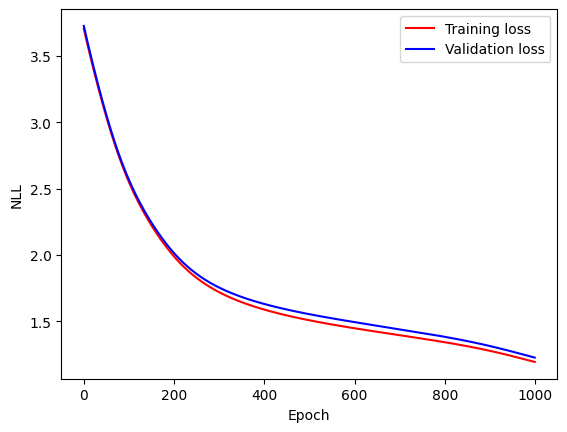

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

# Hyper-parameters
num_epochs = 1000

# Initialize a new network
params = init_rnn(hidden_size=hidden_size, vocab_size=vocab_size)

# Initialize hidden state as zeros
hidden_state = np.zeros((hidden_size, 1))

# Track loss
training_loss, validation_loss = [], []

# For each epoch
for i in range(num_epochs):
    
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
     # For each sentence in validation set
    for inputs, targets in validation_set:
        
        # One-hot encode input and target sequence
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size)
        
        # Re-initialize hidden state
        hidden_state = np.zeros_like(hidden_state)

        # Forward pass
        # YOUR CODE HERE!
        outputs, hidden_states = forward_pass(inputs_one_hot, hidden_state, params)

        # Backward pass
        # YOUR CODE HERE!
        loss, _ = backward_pass(inputs_one_hot, outputs, hidden_states, targets_one_hot, params)
        
        # Update loss
        epoch_validation_loss += loss
    
    # For each sentence in training set
    for inputs, targets in training_set:
        
        # One-hot encode input and target sequence
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size)
        
        # Re-initialize hidden state
        hidden_state = np.zeros_like(hidden_state)

        # Forward pass
        # YOUR CODE HERE!
        outputs, hidden_states = forward_pass(inputs_one_hot, hidden_state, params)

        # Backward pass
        # YOUR CODE HERE!
        loss, grads = backward_pass(inputs_one_hot, outputs, hidden_states, targets_one_hot, params)
        
        if np.isnan(loss):
            raise ValueError('Gradients have vanished!')
        
        # Update parameters
        params = update_parameters(params, grads, lr=3e-4)
        
        # Update loss
        epoch_training_loss += loss
        
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(training_set))
    validation_loss.append(epoch_validation_loss/len(validation_set))

    # Print loss every 100 epochs
    if i % 100 == 0:
        print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')


# Get first sentence in test set
inputs, targets = test_set[1]

# One-hot encode input and target sequence
inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

# Initialize hidden state as zeros
hidden_state = np.zeros((hidden_size, 1))

# Forward pass
outputs, hidden_states = forward_pass(inputs_one_hot, hidden_state, params)
output_sentence = [idx_to_word[np.argmax(output)] for output in outputs]
print('Input sentence:')
print(inputs)

print('\nTarget sequence:')
print(targets)

print('\nPredicted sequence:')
print([idx_to_word[np.argmax(output)] for output in outputs])

# Plot training and validation loss
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

## Exercise:

Complete the training loop above and run the training. You can leave the hyper-parameters and network size unchanged.

A correct implementation should yield a loss **below 1.0** after 2000 epochs. How well does it predict the sequence?

## Extrapolation

Now that we have trained a RNN model, it's time to put it to test. We will provide the network with a starting sentence and let it `freestyle` from there!

In [13]:
def freestyle(params, sentence='', num_generate=4):
    """
    Takes in a sentence as a string and outputs a sequence
    based on the predictions of the RNN.
    
    Args:
     `params`: the parameters of the network
     `sentence`: string with whitespace-separated tokens
     `num_generate`: the number of tokens to generate
    """
    sentence = sentence.split(' ')
    
    sentence_one_hot = one_hot_encode_sequence(sentence, vocab_size)
    
    # Initialize hidden state as zeros
    hidden_state = np.zeros((hidden_size, 1))

    # Generate hidden state for sentence
    outputs, hidden_states = forward_pass(sentence_one_hot, hidden_state, params)
    
    # Output sentence
    output_sentence = sentence
    
    # Append first prediction
    word = idx_to_word[np.argmax(outputs[-1])]    
    output_sentence.append(word)
    
    # Forward pass
    for i in range(num_generate):

        # Get the latest prediction and latest hidden state
        output = outputs[-1]
        hidden_state = hidden_states[-1]
    
        # Reshape our output to match the input shape of our forward pass
        output = output.reshape(1, output.shape[0], output.shape[1])
    
        # Forward pass
        outputs, hidden_states = forward_pass(output, hidden_state, params)
        
        # Compute the index the most likely word and look up the corresponding word
        word = idx_to_word[np.argmax(outputs)]
        
        output_sentence.append(word)
        
    return output_sentence
    
# Perform freestyle
print('Example:')
print(freestyle(params, sentence='a a a a a b'))

Example:
['a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b']


## Exercise:

What did you observe while building and training the model? How well does it freestyle? How many epochs are (roughly) needed for learning to make good predictions?

## Exercise (optional):

Alter the forward pass, backward pass and training loop to handle batches of inputs. You will see a great performance increase!

# Introduction to the Long Short-Term Memory (LSTM) Cell


Reading material: [Christopher Olah's walk-through](http://colah.github.io/posts/2015-08-Understanding-LSTMs/).

___


A vanilla RNN suffers from [the vanishing gradients problem](http://neuralnetworksanddeeplearning.com/chap5.html#the_vanishing_gradient_problem) which gives challenges in saving memory over longer sequences. To combat these issues the gated hidden units were created. The two most prominent gated hidden units are the Long Short-Term Memory (LSTM) cell and the Gated Recurrent Unit (GRU), both of which have shown increased performance in saving and reusing memory in later timesteps. In this exercise, we will focus on LSTM but you would easily be able to go ahead and implement the GRU as well based on the principles that you learn here.

Below is a figure of the LSTM cell:

![lstm](https://i.imgur.com/3VkmUCe.png)
Source: https://arxiv.org/abs/1412.7828


The LSTM cell contains three gates, input, forget, output gates and a memory cell.
The output of the LSTM unit is computed with the following functions, where $\sigma = \mathrm{softmax}$.
We have input gate $i$, forget gate $f$, and output gate $o$ defines as

- $i = \sigma ( W^i [h_{t-1}, x_t])$

- $f = \sigma ( W^f [h_{t-1},x_t])$

- $o = \sigma ( W^o [h_{t-1},x_t])$

where $W^i, W^f, W^o$ are weight matrices applied to a concatenated $h_{t-1}$ (hidden state vector) and $x_t$ (input vector)  for each respective gate.

$h_{t-1}$, from the previous time step along with the current input $x_t$ are used to compute the a candidate $g$

- $g = \mathrm{tanh}( W^g [h_{t-1}, x_t])$

The value of the cell's memory, $c_t$, is updated as

- $c_t = c_{t-1} \circ f + g \circ i$

where $c_{t-1}$ is the previous memory, and $\circ$ refers to element-wise multiplication.

The output, $h_t$, is computed as

- $h_t = \mathrm{tanh}(c_t) \circ o$

and it is used for both the timestep's output and the next timestep, whereas $c_t$ is exclusively sent to the next timestep.
This makes $c_t$ a memory feature, and is not used directly to compute the output of the timestep.

## Initialiation of a LSTM network

Similarly to before we will implement the forward pass, backward pass, optimization and training loop, now for an LSTM in numpy. Later, we will go back to PyTorch and appreciate how convenient the implementation becomes.

In [14]:
# Size of concatenated hidden + input vector
z_size = hidden_size + vocab_size 

def init_lstm(hidden_size, vocab_size, z_size):
    """
    Initializes our LSTM network.
    
    Args:
     `hidden_size`: the dimensions of the hidden state
     `vocab_size`: the dimensions of our vocabulary
     `z_size`: the dimensions of the concatenated input 
    """
    # Weight matrix (forget gate)
    # YOUR CODE HERE!
    W_f = np.random.randn(hidden_size, z_size)
    
    # Bias for forget gate
    b_f = np.zeros((hidden_size, 1))

    # Weight matrix (input gate)
    # YOUR CODE HERE!
    W_i = np.random.randn(hidden_size, z_size)
    
    # Bias for input gate
    b_i = np.zeros((hidden_size, 1))

    # Weight matrix (candidate)
    # YOUR CODE HERE!
    W_g = np.random.randn(hidden_size, z_size)
    
    # Bias for candidate
    b_g = np.zeros((hidden_size, 1))

    # Weight matrix of the output gate
    # YOUR CODE HERE!
    W_o = np.random.randn(hidden_size, z_size)
    b_o = np.zeros((hidden_size, 1))

    # Weight matrix relating the hidden-state to the output
    # YOUR CODE HERE!
    W_v = np.random.randn(vocab_size, hidden_size)
    b_v = np.zeros((vocab_size, 1))
    
    # Initialize weights according to https://arxiv.org/abs/1312.6120
    W_f = init_orthogonal(W_f)
    W_i = init_orthogonal(W_i)
    W_g = init_orthogonal(W_g)
    W_o = init_orthogonal(W_o)
    W_v = init_orthogonal(W_v)

    return W_f, W_i, W_g, W_o, W_v, b_f, b_i, b_g, b_o, b_v


params = init_lstm(hidden_size=hidden_size, vocab_size=vocab_size, z_size=z_size)

## Exercise:

Implement the initlizations in the code above. Refer to the equations and the figure if you're in doubt.

## Forward pass

As before we need to bring the equations into pieces of code. This is done in the following function:

In [15]:
def forward(inputs, h_prev, C_prev, p):
    """
    Arguments:
    x -- your input data at timestep "t", numpy array of shape (n_x, m).
    h_prev -- Hidden state at timestep "t-1", numpy array of shape (n_a, m)
    C_prev -- Memory state at timestep "t-1", numpy array of shape (n_a, m)
    p -- python list containing:
                        W_f -- Weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        b_f -- Bias of the forget gate, numpy array of shape (n_a, 1)
                        W_i -- Weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        b_i -- Bias of the update gate, numpy array of shape (n_a, 1)
                        W_g -- Weight matrix of the first "tanh", numpy array of shape (n_a, n_a + n_x)
                        b_g --  Bias of the first "tanh", numpy array of shape (n_a, 1)
                        W_o -- Weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        b_o --  Bias of the output gate, numpy array of shape (n_a, 1)
                        W_v -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_v, n_a)
                        b_v -- Bias relating the hidden-state to the output, numpy array of shape (n_v, 1)
    Returns:
    z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s -- lists of size m containing the computations in each forward pass
    outputs -- prediction at timestep "t", numpy array of shape (n_v, m)
    """
    assert h_prev.shape == (hidden_size, 1)
    assert C_prev.shape == (hidden_size, 1)

    # First we unpack our parameters
    W_f, W_i, W_g, W_o, W_v, b_f, b_i, b_g, b_o, b_v = p
    
    # Save a list of computations for each of the components in the LSTM
    x_s, z_s, f_s, i_s,  = [], [] ,[], []
    g_s, C_s, o_s, h_s = [], [] ,[], []
    v_s, output_s =  [], [] 
    
    # Append the initial cell and hidden state to their respective lists
    h_s.append(h_prev)
    C_s.append(C_prev)
    
    for x in inputs:
        
        # YOUR CODE HERE!
        # Concatenate input and hidden state
        z = np.row_stack((h_prev, x))
        z_s.append(z)
        
        # YOUR CODE HERE!
        # Calculate forget gate
        f = sigmoid(np.dot(W_f, z) + b_f)
        f_s.append(f)
        
        # Calculate input gate
        i = sigmoid(np.dot(W_i, z) + b_i)
        i_s.append(i)
        
        # Calculate candidate
        g = tanh(np.dot(W_g, z) + b_g)
        g_s.append(g)
        
        # YOUR CODE HERE!
        # Calculate memory state
        C_prev = f * C_prev + i * g 
        C_s.append(C_prev)
        
        # Calculate output gate
        o = sigmoid(np.dot(W_o, z) + b_o)
        o_s.append(o)
        
        # Calculate hidden state
        h_prev = o * tanh(C_prev)
        h_s.append(h_prev)

        # Calculate logits
        v = np.dot(W_v, h_prev) + b_v
        v_s.append(v)
        
        # Calculate softmax
        output = softmax(v)
        output_s.append(output)

    return z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, output_s


# Get first sentence in test set
inputs, targets = test_set[1]

# One-hot encode input and target sequence
inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

# Initialize hidden state as zeros
h = np.zeros((hidden_size, 1))
c = np.zeros((hidden_size, 1))

# Forward pass
z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs = forward(inputs_one_hot, h, c, params)

output_sentence = [idx_to_word[np.argmax(output)] for output in outputs]
print('Input sentence:')
print(inputs)

print('\nTarget sequence:')
print(targets)

print('\nPredicted sequence:')
print([idx_to_word[np.argmax(output)] for output in outputs])

Input sentence:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b']

Target sequence:
['a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']

Predicted sequence:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'EOS']


## Exercise:

Complete the implementation of the LSTM forward pass above. Refer to the equations and figures further up if you're in doubt.

## Backward pass

Similar to the RNN in numpy we also need to specify a backward pass. Fortunately some of the TA's have a lot of free time to do that for you :-) 

In [16]:
def backward(z, f, i, g, C, o, h, v, outputs, targets, p = params):
    """
    Arguments:
    z -- your concatenated input data  as a list of size m.
    f -- your forget gate computations as a list of size m.
    i -- your input gate computations as a list of size m.
    g -- your candidate computations as a list of size m.
    C -- your Cell states as a list of size m+1.
    o -- your output gate computations as a list of size m.
    h -- your Hidden state computations as a list of size m+1.
    v -- your logit computations as a list of size m.
    outputs -- your outputs as a list of size m.
    targets -- your targets as a list of size m.
    p -- python list containing:
                        W_f -- Weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        b_f -- Bias of the forget gate, numpy array of shape (n_a, 1)
                        W_i -- Weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        b_i -- Bias of the update gate, numpy array of shape (n_a, 1)
                        W_g -- Weight matrix of the first "tanh", numpy array of shape (n_a, n_a + n_x)
                        b_g --  Bias of the first "tanh", numpy array of shape (n_a, 1)
                        W_o -- Weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        b_o --  Bias of the output gate, numpy array of shape (n_a, 1)
                        W_v -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_v, n_a)
                        b_v -- Bias relating the hidden-state to the output, numpy array of shape (n_v, 1)
    Returns:
    loss -- crossentropy loss for all elements in output
    grads -- lists of gradients of every element in p
    """

    # Unpack parameters
    W_f, W_i, W_g, W_o, W_v, b_f, b_i, b_g, b_o, b_v = p

    # Initialize gradients as zero
    W_f_d = np.zeros_like(W_f)
    b_f_d = np.zeros_like(b_f)

    W_i_d = np.zeros_like(W_i)
    b_i_d = np.zeros_like(b_i)

    W_g_d = np.zeros_like(W_g)
    b_g_d = np.zeros_like(b_g)

    W_o_d = np.zeros_like(W_o)
    b_o_d = np.zeros_like(b_o)

    W_v_d = np.zeros_like(W_v)
    b_v_d = np.zeros_like(b_v)
    
    # Set the next cell and hidden state equal to zero
    dh_next = np.zeros_like(h[0])
    dC_next = np.zeros_like(C[0])
        
    # Track loss
    loss = 0
    
    for t in reversed(range(len(outputs))):
        
        # Compute the cross entropy
        loss += -np.mean(np.log(outputs[t]) * targets[t])
        # Get the previous hidden cell state
        C_prev= C[t-1]
        
        # Compute the derivative of the relation of the hidden-state to the output gate
        dv = np.copy(outputs[t])
        dv[np.argmax(targets[t])] -= 1

        # Update the gradient of the relation of the hidden-state to the output gate
        W_v_d += np.dot(dv, h[t].T)
        b_v_d += dv

        # Compute the derivative of the hidden state and output gate
        dh = np.dot(W_v.T, dv)        
        dh += dh_next
        do = dh * tanh(C[t])
        do = sigmoid(o[t], derivative=True)*do
        
        # Update the gradients with respect to the output gate
        W_o_d += np.dot(do, z[t].T)
        b_o_d += do

        # Compute the derivative of the cell state and candidate g
        dC = np.copy(dC_next)
        dC += dh * o[t] * tanh(tanh(C[t]), derivative=True)
        dg = dC * i[t]
        dg = tanh(g[t], derivative=True) * dg
        
        # Update the gradients with respect to the candidate
        W_g_d += np.dot(dg, z[t].T)
        b_g_d += dg

        # Compute the derivative of the input gate and update its gradients
        di = dC * g[t]
        di = sigmoid(i[t], True) * di
        W_i_d += np.dot(di, z[t].T)
        b_i_d += di

        # Compute the derivative of the forget gate and update its gradients
        df = dC * C_prev
        df = sigmoid(f[t]) * df
        W_f_d += np.dot(df, z[t].T)
        b_f_d += df

        # Compute the derivative of the input and update the gradients of the previous hidden and cell state
        dz = (np.dot(W_f.T, df)
             + np.dot(W_i.T, di)
             + np.dot(W_g.T, dg)
             + np.dot(W_o.T, do))
        dh_prev = dz[:hidden_size, :]
        dC_prev = f[t] * dC
        
    grads= W_f_d, W_i_d, W_g_d, W_o_d, W_v_d, b_f_d, b_i_d, b_g_d, b_o_d, b_v_d
    
    # Clip gradients
    grads = clip_gradient_norm(grads)
    
    return loss, grads


# Perform a backward pass
loss, grads = backward(z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs, targets_one_hot, params)

print('We get a loss of:')
print(loss)

We get a loss of:
4.940597374930116


## Training loop

Now let's see if the LSTM works after being trained for a few epochs.

Epoch 0, training loss: 2.9126594208151486, validation loss: 3.7627056786333304
Epoch 5, training loss: 1.2746721453770284, validation loss: 1.3007947595266
Epoch 10, training loss: 1.1492599735091495, validation loss: 1.139792652078412
Epoch 15, training loss: 0.9836092135358963, validation loss: 0.9939491353315223
Epoch 20, training loss: 0.8791899647621022, validation loss: 0.897521967827773
Epoch 25, training loss: 0.8008628436073781, validation loss: 0.818870240165999
Epoch 30, training loss: 0.7547721298664057, validation loss: 0.7598792343202017
Epoch 35, training loss: 0.7316903442197216, validation loss: 0.7280875207336992
Epoch 40, training loss: 0.7181688528186635, validation loss: 0.7100343175260166
Epoch 45, training loss: 0.7091859818959982, validation loss: 0.6989779674003701
Input sentence:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b']

Target sequence:
['a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']

Predicted sequence:

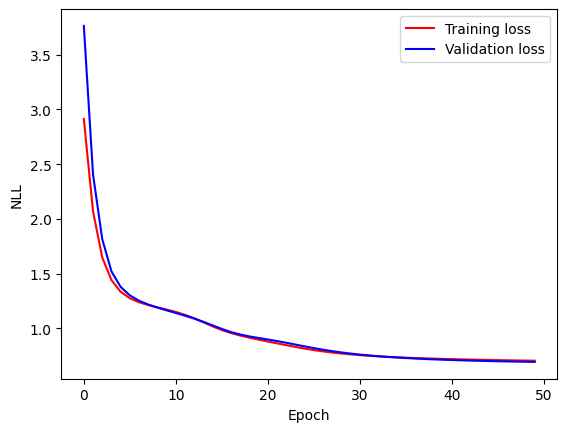

In [17]:
# Hyper-parameters
num_epochs = 50

# Initialize a new network
z_size = hidden_size + vocab_size # Size of concatenated hidden + input vector
params = init_lstm(hidden_size=hidden_size, vocab_size=vocab_size, z_size=z_size)

# Initialize hidden state as zeros
hidden_state = np.zeros((hidden_size, 1))

# Track loss
training_loss, validation_loss = [], []

# For each epoch
for i in range(num_epochs):
    
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
    # For each sentence in validation set
    for inputs, targets in validation_set:
        
        # One-hot encode input and target sequence
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

        # Initialize hidden state and cell state as zeros
        h = np.zeros((hidden_size, 1))
        c = np.zeros((hidden_size, 1))

        # Forward pass
        z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs = forward(inputs_one_hot, h, c, params)
        
        # Backward pass
        loss, _ = backward(z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs, targets_one_hot, params)
        
        # Update loss
        epoch_validation_loss += loss
    
    # For each sentence in training set
    for inputs, targets in training_set:
        
        # One-hot encode input and target sequence
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

        # Initialize hidden state and cell state as zeros
        h = np.zeros((hidden_size, 1))
        c = np.zeros((hidden_size, 1))

        # Forward pass
        z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs = forward(inputs_one_hot, h, c, params)
        
        # Backward pass
        loss, grads = backward(z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs, targets_one_hot, params)
        
        # Update parameters
        params = update_parameters(params, grads, lr=1e-1)
        
        # Update loss
        epoch_training_loss += loss
                
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(training_set))
    validation_loss.append(epoch_validation_loss/len(validation_set))

    # Print loss every 5 epochs
    if i % 5 == 0:
        print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')


    
# Get first sentence in test set
inputs, targets = test_set[1]

# One-hot encode input and target sequence
inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

# Initialize hidden state as zeros
h = np.zeros((hidden_size, 1))
c = np.zeros((hidden_size, 1))

# Forward pass
z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs = forward(inputs_one_hot, h, c, params)

# Print example
print('Input sentence:')
print(inputs)

print('\nTarget sequence:')
print(targets)

# print('\nPredicted sequence:')
# print([idx_to_word[np.argmax(output)] for output in outputs])

print('\nPredicted sequence:')
predicted = [idx_to_word[np.argmax(output)] for output in outputs]
print(predicted)
print(f'Is predicted equal to target?: {predicted == targets}')  

# Plot training and validation loss
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

## Exercise:

Run the training loop above. What do you notice about the loss and number of epochs compared to the vanilla RNN from earlier?

## PyTorch implementation of the LSTM

Now that we know how the LSTM cell works, let's see how easy it is to use in PyTorch!

Definition of our LSTM network. We define a LSTM layer using the [nn.LSTM](https://pytorch.org/docs/stable/nn.html#lstm) class. The LSTM layer takes as argument the size of the input and the size of the hidden state like in our numpy implementation.

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Recurrent layer
        # YOUR CODE HERE!
        self.lstm = nn.LSTM(input_size=vocab_size,
                         hidden_size=50,
                         num_layers=1,
                         bidirectional=False)
        
        # Output layer
        self.l_out = nn.Linear(in_features=50,
                            out_features=vocab_size,
                            bias=False)
        
    def forward(self, x):
        # RNN returns output and last hidden state
        x, (h, c) = self.lstm(x)
        
        # Flatten output for feed-forward layer
        x = x.view(-1, self.lstm.hidden_size)
        
        # Output layer
        x = self.l_out(x)
        
        return x

net = Net()
print(net)

Net(
  (lstm): LSTM(4, 50)
  (l_out): Linear(in_features=50, out_features=4, bias=False)
)


### Training loop

It's time for us to train our network. In the section below, you will get to put your deep learning skills to use and create your own training loop. You may want to consult previous exercises if you cannot recall how to define the training loop.

Epoch 0, training loss: 1.3135319113731385, validation loss: 1.3810699343681336
Epoch 5, training loss: 0.7477201532572508, validation loss: 0.8005615592002868
Epoch 10, training loss: 0.5472888477146626, validation loss: 0.59722019135952
Epoch 15, training loss: 0.4557153906673193, validation loss: 0.49569823443889616
Epoch 20, training loss: 0.40496079064905643, validation loss: 0.43303193151950836
Epoch 25, training loss: 0.3765683703124523, validation loss: 0.40286846160888673
Epoch 30, training loss: 0.35720155723392966, validation loss: 0.38106810450553896
Epoch 35, training loss: 0.34277838096022606, validation loss: 0.36382968425750734
Epoch 40, training loss: 0.3315416814759374, validation loss: 0.349763123691082
Epoch 45, training loss: 0.32268852554261684, validation loss: 0.33821784853935244

Input sequence:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b']

Target sequence:
['a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']

Predi

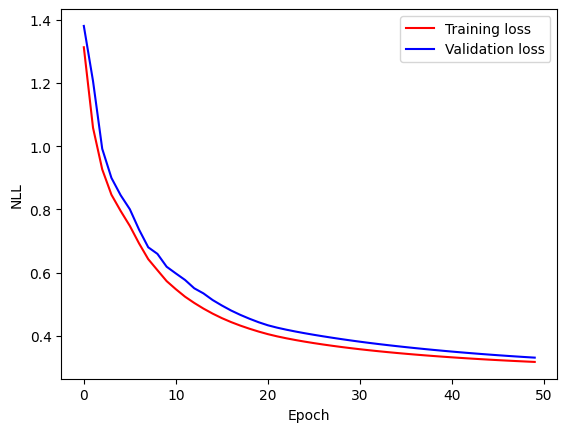

In [19]:
# Hyper-parameters
num_epochs = 50

# Initialize a new network
net = Net()

# Define a loss function and optimizer for this problem
# YOUR CODE HERE!
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)

# Track loss
training_loss, validation_loss = [], []

# For each epoch
for i in range(num_epochs):
    
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
    net.eval()
        
    # For each sentence in validation set
    for inputs, targets in validation_set:
        
        # One-hot encode input and target sequence
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_idx = [word_to_idx[word] for word in targets]
        
        # Convert input to tensor
        inputs_one_hot = torch.Tensor(inputs_one_hot)
        inputs_one_hot = inputs_one_hot.permute(0, 2, 1)
        
        # Convert target to tensor
        targets_idx = torch.LongTensor(targets_idx)
        
        # Forward pass
        # YOUR CODE HERE!
        outputs = net.forward(inputs_one_hot)
        
        # Compute loss
        # YOUR CODE HERE!
        loss = criterion(outputs, targets_idx)
        
        # Update loss
        epoch_validation_loss += loss.detach().numpy()
    
    net.train()
    
    # For each sentence in training set
    for inputs, targets in training_set:
        
        # One-hot encode input and target sequence
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_idx = [word_to_idx[word] for word in targets]
        
        # Convert input to tensor
        inputs_one_hot = torch.Tensor(inputs_one_hot)
        inputs_one_hot = inputs_one_hot.permute(0, 2, 1)
        
        # Convert target to tensor
        targets_idx = torch.LongTensor(targets_idx)
        
        # Forward pass
        # YOUR CODE HERE!
        outputs = net.forward(inputs_one_hot)
        
        # Compute loss
        # YOUR CODE HERE!
        loss = criterion(outputs, targets_idx)
        
        # Backward pass
        # YOUR CODE HERE!
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update loss
        epoch_training_loss += loss.detach().numpy()
        
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(training_set))
    validation_loss.append(epoch_validation_loss/len(validation_set))

    # Print loss every 5 epochs
    if i % 5 == 0:
        print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')

        
# Get first sentence in test set
inputs, targets = test_set[1]

# One-hot encode input and target sequence
inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
targets_idx = [word_to_idx[word] for word in targets]

# Convert input to tensor
inputs_one_hot = torch.Tensor(inputs_one_hot)
inputs_one_hot = inputs_one_hot.permute(0, 2, 1)

# Convert target to tensor
targets_idx = torch.LongTensor(targets_idx)

# Forward pass
# YOUR CODE HERE!
outputs = net.forward(inputs_one_hot).data.numpy()

print('\nInput sequence:')
print(inputs)

print('\nTarget sequence:')
print(targets)

print('\nPredicted sequence:')
print([idx_to_word[np.argmax(output)] for output in outputs])

# Plot training and validation loss
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

## Exercise:

Finish the training loop above and run the training. Compare your loss to the numpy implementation. Are they similar?

Try to play around with the hyper-parameters and hidden dimensions. How low of a negative log-likelihood can you achieve?

## Exercise (optional)

Aside from the LSTM cell, various other RNN cells exist. The gated recurrent unit (GRU) is a variation of the LSTM cell that uses less parameters. Try to look it up in the [PyTorch documentation](https://pytorch.org/docs/stable/nn.html#gru) and switch out the LSTM cell in the code above. What do you notice in terms of performance and convergence speed?

# Where to go from here?

In this notebook you have learned how to use embeddings, recurrent neural networks and the LSTM cell in particular.

As we have already seen, RNNs are excellent for sequential data such as language. But what do we do if we're modelling data with strong dependency in both directions? Like in many things deep learning, we can build powerful models by stacking layers on top of each other: *bi-directional* RNNs consist of two LSTM cells, one for each direction. A sequence is first fed into the forward LSTM cell and the reversed sequence is then used as input to the backward LSTM cell together with the last hidden state from the forward LSTM cell. Follow [this link](https://pdfs.semanticscholar.org/4b80/89bc9b49f84de43acc2eb8900035f7d492b2.pdf) for the original paper from 1997(!).

For even deeper representations, multiple layers of both uni-directional and bi-directional RNNs can be stacked ontop of each other, just like feed-forward and convolutional layers! For more information on this, check out the [LSTM PyTorch documentation](https://pytorch.org/docs/stable/nn.html#lstm).